# This is experiments with full paths only

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch as t
from torch import nn, Tensor
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from dataclasses import dataclass
import numpy as np
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple
from functools import partial
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
from rich.table import Table
from IPython.display import display, HTML
from pathlib import Path

import jaxtyping

In [3]:
import sys
# Make sure exercises are in the path
exercises_dir = Path("../scripts").resolve()
section_dir = (exercises_dir / "part4_superposition_and_saes").resolve()
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from model import Tree, Config, Model, construct_tree, Node

from plotly_utils import imshow, line, hist
from utils import (
    plot_features_in_2d,
    plot_features_in_Nd,
    plot_features_in_Nd_discrete,
    plot_correlated_features,
    plot_feature_geometry,
    frac_active_line_plot,
    plot_features_in_2d_hierarchy_labeled
)
# import part4_superposition_and_saes.tests as tests
# import part4_superposition_and_saes.solutions as solutions

if t.backends.mps.is_available():
    print("current PyTorch install was "
              "built with MPS enabled.")
    if t.backends.mps.is_built():
        print("MPS is available")
        device = t.device("mps")
else:
    device = t.device("cuda" if t.cuda.is_available() else "cpu")

current PyTorch install was built with MPS enabled.
MPS is available


# Functions

In [4]:
# plot the first instance as a bar chart for batch_data and model(batch_data)
import matplotlib.pyplot as plt

# Plot the first instance of batch_data
import plotly.graph_objects as go

def plot_batch_data(batch_data, model_output_data, tree, i):    # Get the list of tree paths
    tree_paths = tree.to_list()
    fig = go.Figure(data=[
        go.Scatter(
            x=tree_paths,
            y=batch_data[0, i].cpu().numpy(),
            mode='lines',
            name='Batch Data',
            hovertemplate='%{x}<br>%{y}'
        ),
        go.Scatter(
            x=tree_paths,
            y=model_output_data[0, i].detach().cpu().numpy(),
            mode='lines',
            name='Model Output',
            hovertemplate='%{x}<br>%{y}'
        )
    ])

    fig.update_layout(
        title='First Instance of Batch Data and Model Output',
        yaxis_title='Value',
        width=1200,
        height=600,
        legend_title='Data Source',
        xaxis=dict(
            showticklabels=False,
            title=None,
            hoverformat='%{x}'
        )
    )

    fig.show()

In [5]:
def get_index_from_path(path, tree):
    node_list = tree.to_list()
    return node_list.index(path)

def get_mean_from_index(index1, index2, model):
    W = model.W.detach().cpu()
    return (W[:, :, index1] + W[:, :, index2])/2

cos = nn.CosineSimilarity(dim=1, eps=1e-6)

def get_cosine_similarity(index1, index2, model):
    W = model.W.detach().cpu()
    return cos(W[:,:,index1], W[:,:,index2])

def get_cosine_similarity_dict(model, depth, partial_paths = False):
    cosine_similarities = {}
    for i in model.cfg.tree.to_list():
        # if i has children, get cosine similarity of i and its children
        current_depth = i.count(".") + 1
        if current_depth < depth:
            parent_idx = get_index_from_path(i, model.cfg.tree)
            children1_idx = get_index_from_path(f"{i}.0", model.cfg.tree)
            children2_idx = get_index_from_path(f"{i}.1", model.cfg.tree)
            if partial_paths:
                cosine_similarities[(i, f"{i}.0")] = {
                    "similarity": get_cosine_similarity(parent_idx, children1_idx, model).mean().item(),
                    "depth": current_depth
                }
                cosine_similarities[(i, f"{i}.1")] = {
                    "similarity": get_cosine_similarity(parent_idx, children2_idx, model).mean().item(),
                    "depth": current_depth
                }
            else: ## get mean of two children as pseudo parent
                W = model.W.detach().cpu()
                pseudo_parent = get_mean_from_index(children1_idx, children2_idx, model)
                children1_minux_pseudo_parent = W[:,:,children1_idx] - pseudo_parent
                children2_minux_pseudo_parent = W[:,:,children2_idx] - pseudo_parent
                cosine_similarities[(i, i + ".0")] = {
                    "similarity": cos(pseudo_parent, children1_minux_pseudo_parent).mean().item(),
                    "depth": current_depth
                }
                cosine_similarities[(i, i + ".1")] = {
                    "similarity": cos(pseudo_parent, children2_minux_pseudo_parent).mean().item(),
                    "depth": current_depth
                }
    
    return cosine_similarities

In [6]:
def plot_cosine_similarity_dict(model, depth, partial_paths = False, y_min = -0.1):
    cosine_similarities = get_cosine_similarity_dict(model, depth, partial_paths)
    ## plot cosine_similarities as a histogram
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    similarities = [data['similarity'] for data in cosine_similarities.values()]
    depths = [data['depth'] for data in cosine_similarities.values()]
    plt.scatter(depths, similarities, alpha=0.5)
    plt.title(f"Cosine Similarities vs Depth (n_hidden={model.cfg.n_hidden})")
    plt.xlabel("Depth")
    plt.ylabel("Cosine Similarity")
    plt.ylim(y_min, 1.0)  # Set y-axis range from -0.1 to 1.0
    # plt.colorbar(label="Depth")
    plt.show()
    return cosine_similarities

# Try small tree depths (Depth 2 ~ 4)

## Tree Depth of 2

In [7]:
tree_2 = construct_tree(branching_factor = 2, depth = 2)
len(tree_2.to_list())
tree_2.to_list()

['0', '0.0', '0.1', '1', '1.0', '1.1']

In [12]:
cfg = Config(
    n_instances = 6,
    tree = tree_2,
    n_hidden = 1,
    partial_paths = False,
    n_features = len(tree_2.to_list())
)

model_2_1 = Model(
    cfg = cfg,
    device = device,
)
model_2_1.optimize(steps=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [11]:
cfg = Config(
    n_instances = 6,
    tree = tree_2,
    n_hidden = 2,
    partial_paths = False,
    n_features = len(tree_2.to_list())
)

model_2_2 = Model(
    cfg = cfg,
    device = device,
)
model_2_2.optimize(steps=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
batch_data = model_2_2.generate_batch(1)
model_output_data = model_2_2(batch_data)
plot_batch_data(batch_data, model_output_data, tree_2, 0)

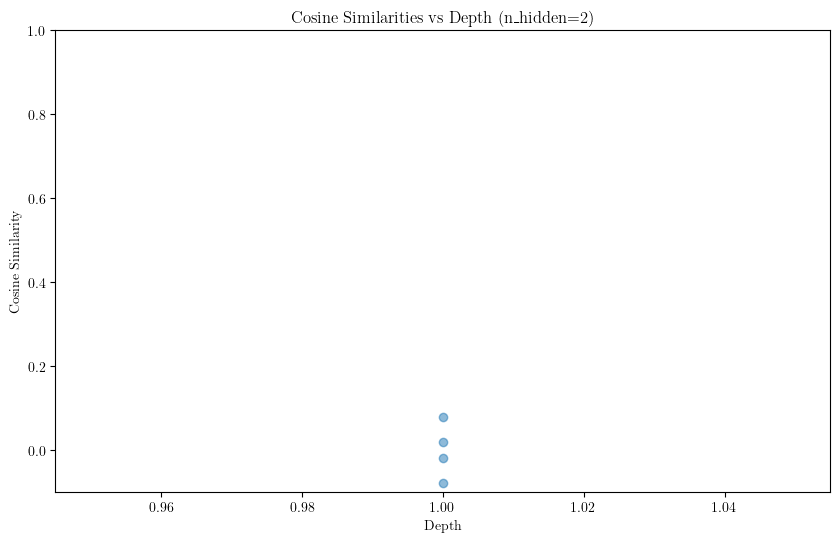

In [53]:
cosine_similarities =plot_cosine_similarity_dict(model_2_2, 2, partial_paths = False)

In [52]:
import torch
import plotly.graph_objects as go
import numpy as np

# Convert the tensor to numpy for easier handling
W_2d_np = model_2_2.W.detach().cpu().numpy()[0, ...]

# Create a figure
fig = go.Figure()

# Define colors for each level of the tree
colors = ['blue', 'green', 'red']

# Function to add a vector to the plot
def add_vector(start, end, name, color):
    fig.add_trace(go.Scatter(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        mode='lines+markers',
        name=name,
        line=dict(width=2, color=color),
        marker=dict(size=8, color=color)
    ))

# Plot level 1 (parent nodes)
for i in [0, 3]:
    start = np.zeros(2)
    end = W_2d_np[:, i]
    add_vector(start, end, f'Vector {i}', colors[0])

# Plot level 2 (children of node 0)
parent = W_2d_np[:, 0]
for i in range(1, 3):
    start = parent
    end = parent + W_2d_np[:, i]
    add_vector(start, end, f'Vector {i}', colors[1])

# Plot level 3 (children of node 1)
parent = W_2d_np[:, 3]
for i in range(4, 6):
    start = parent
    end = parent + W_2d_np[:, i]
    add_vector(start, end, f'Vector {i}', colors[2])

# Set layout
fig.update_layout(
    title='2D Vector Binary Tree Visualization',
    xaxis=dict(title='X', range=[-2, 2]),
    yaxis=dict(title='Y', range=[-2, 2]),
    showlegend=True,
    width=600, height=600
)

# Show the plot
fig.show()

## Tree Depth of 3


In [55]:
tree_3 = construct_tree(branching_factor = 2, depth = 3)
len(tree_3.to_list())

14

In [56]:
cfg = Config(
    n_instances = 6,
    tree = tree_3,
    n_hidden = 2,
    partial_paths = False,
    n_features = len(tree_3.to_list())
)

model_3_2 = Model(
    cfg = cfg,
    device = device,
)
model_3_2.optimize(steps=10000)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [57]:
cfg = Config(
    n_instances = 6,
    tree = tree_3,
    n_hidden = 3,
    partial_paths = False,
    n_features = len(tree_3.to_list())
)

model_3_3 = Model(
    cfg = cfg,
    device = device,
)
model_3_3.optimize(steps=10000)
batch_data = model_3_3.generate_batch(1)
model_output_data = model_3_3(batch_data)
plot_batch_data(batch_data, model_output_data, tree_3, 0)

  0%|          | 0/10000 [00:00<?, ?it/s]

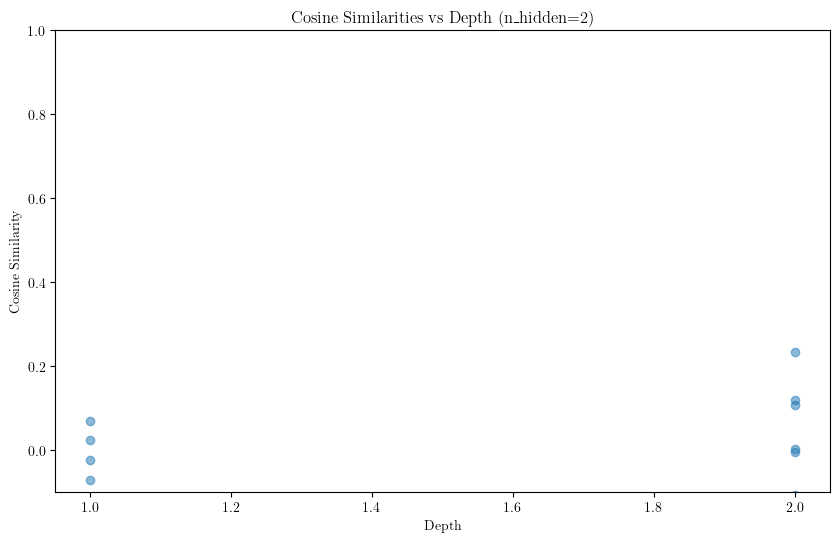

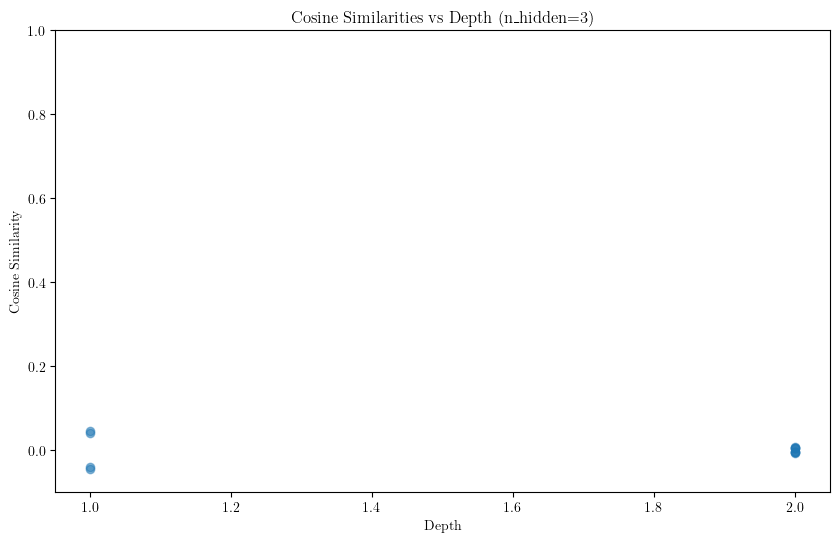

In [58]:
cosine_similarities =plot_cosine_similarity_dict(model_3_2, 3)
cosine_similarities =plot_cosine_similarity_dict(model_3_3, 3)


In [62]:
import torch
import plotly.graph_objects as go
import numpy as np

# Assuming W_3d is your tensor with shape [3, 6]
# If you don't have this tensor, you can create a random one for testing:
# W_3d = torch.rand(3, 6)

# Convert the tensor to numpy for easier handling
W_3d_np = model_3_3.W.detach().cpu().numpy()[0, ...]
tree_list = tree_3.to_list()

# Create a figure
fig = go.Figure()

# Define colors for each level of the tree
colors = ['blue', 'green', 'red']

# Function to add a vector to the plot
def add_vector(start, end, name, color):
    fig.add_trace(go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        name=name,
        line=dict(width=5, color=color)
    ))
    fig.add_trace(go.Scatter3d(
        x=[end[0]],
        y=[end[1]],
        z=[end[2]],
        mode='markers',
        name=f'{name} end',
        marker=dict(size=5, color=color)
    ))

# Plot level 1 (parent nodes)
# for i in range(2):
for i in ["0", "1"]:
    start = np.zeros(3)
    end = W_3d_np[:, tree_list.index(i)]
    add_vector(start, end, f'Vector {i}', colors[0])

# Plot level 2 (children of node 0)
parent = W_3d_np[:, tree_list.index("0")]
for i in ["0.0", "0.1"]:
    start = parent
    end = parent + W_3d_np[:, tree_list.index(i)]
    add_vector(start, end, f'Vector {i}', colors[1])

# Plot level 3 (children of node 1)
parent = W_3d_np[:, tree_list.index("1")]
for i in ["1.0", "1.1"]:
    start = parent
    end = parent + W_3d_np[:, tree_list.index(i)]
    add_vector(start, end, f'Vector {i}', colors[2])

# Set layout
fig.update_layout(
    title='3D Vector Binary Tree Visualization',
    scene=dict(
        xaxis=dict(range=[-2, 2], title='X'),
        yaxis=dict(range=[-2, 2], title='Y'),
        zaxis=dict(range=[-2, 2], title='Z'),
        aspectmode='cube'
    ),
    # scene=dict(
    #     xaxis_title='X',
    #     yaxis_title='Y',
    #     zaxis_title='Z',
    #     aspectmode='cube'  # This ensures the 3D space is a cube
    # ),
    showlegend=True,
    width=600, height=600
)

# Show the plot
fig.show()

## Tree Depth of 4


In [63]:
tree_4 = construct_tree(branching_factor = 2, depth = 4)
len(tree_4.to_list())
cfg = Config(
    n_instances = 6,
    tree = tree_4,
    n_hidden = 3,
    partial_paths = False,
    n_features = len(tree_4.to_list())
)

model_4_3 = Model(
    cfg = cfg,
    device = device,
)
model_4_3.optimize(steps=10000)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [64]:
cfg = Config(
    n_instances = 6,
    tree = tree_4,
    n_hidden = 4,
    partial_paths = False,
    n_features = len(tree_4.to_list())
)

model_4_4 = Model(
    cfg = cfg,
    device = device,
)
model_4_4.optimize(steps=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

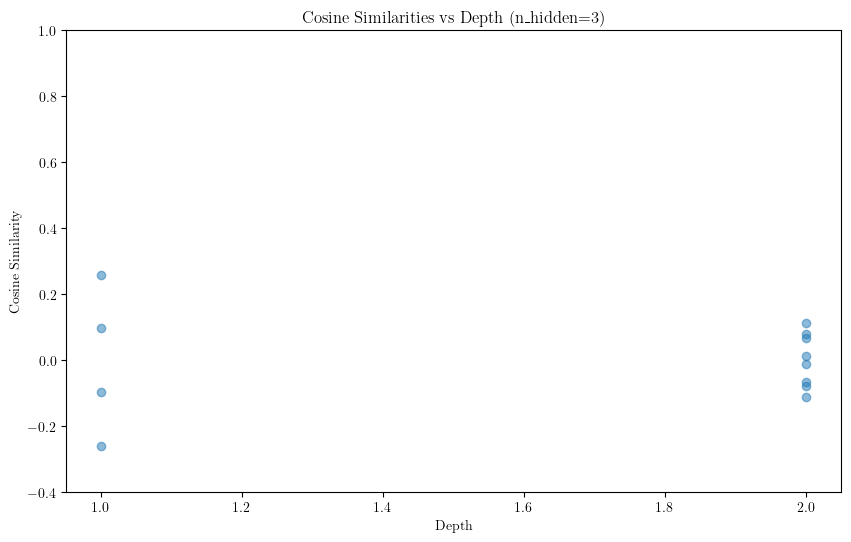

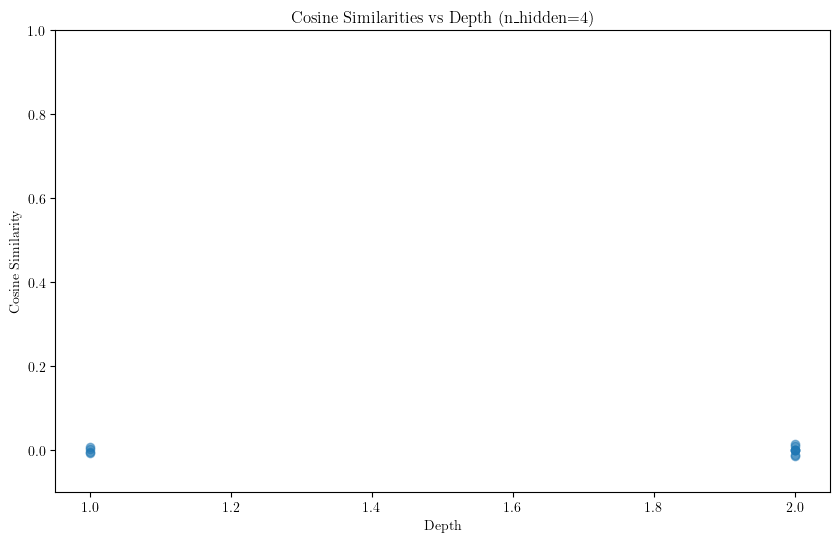

In [67]:
cosine_similarities =plot_cosine_similarity_dict(model_4_3, 3, y_min = -0.4)
cosine_similarities =plot_cosine_similarity_dict(model_4_4, 3)


# Try a unique tree

## Tree with two parent nodes, one with three children, and one with no children

In [17]:
# Create a tree with two nodes, and only one of the nodes has three children
unique_tree = Node("root")
unique_tree.add_child(Node("child1"))
node_with_children = Node("child2")
node_with_children.add_child(Node("grandchild1"))
node_with_children.add_child(Node("grandchild2"))
node_with_children.add_child(Node("grandchild3"))
unique_tree.add_child(node_with_children)

unique_tree = Tree(unique_tree)
# Visualize the tree structure
print(unique_tree.to_list())


['0', '1', '1.0', '1.1', '1.2']


In [18]:
cfg = Config(
    n_instances = 6,
    tree = unique_tree,
    n_hidden = 2,
    partial_paths = False,
    n_features = len(unique_tree.to_list())
)

model_unique = Model(
    cfg = cfg,
    device = device,
)
model_unique.optimize(steps=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
model_unique.optimize(steps=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [25]:
import torch
import plotly.graph_objects as go
import numpy as np

# Convert the tensor to numpy for easier handling
W_2d_np = model_unique.W.detach().cpu().numpy()[0, ...]
tree_list = unique_tree.to_list()
# Create a figure
fig = go.Figure()

# Define colors for each level of the tree
colors = ['blue', 'green', 'red']

# Function to add a vector to the plot
def add_vector(start, end, name, color):
    fig.add_trace(go.Scatter(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        mode='lines+markers',
        name=name,
        line=dict(width=2, color=color),
        marker=dict(size=8, color=color)
    ))

# Plot level 1 (parent nodes)
# for i in range(2):
for i in ["0", "1"]:
    start = np.zeros(3)
    end = W_2d_np[:, tree_list.index(i)]
    add_vector(start, end, f'Vector {i}', colors[int(i)])


# Plot level 3 (children of node 1)
parent = W_2d_np[:, tree_list.index("1")]
for i in ["1.0", "1.1", "1.2"]:
    start = parent
    end = parent + W_2d_np[:, tree_list.index(i)]
    add_vector(start, end, f'Vector {i}', colors[2])

# Set layout
fig.update_layout(
    title='2D Vector Binary Tree Visualization',
    xaxis=dict(title='X', range=[-2, 2]),
    yaxis=dict(title='Y', range=[-2, 2]),
    showlegend=True,
    width=600, height=600
)

# Show the plot
fig.show()

In [26]:
cfg = Config(
    n_instances = 6,
    tree = unique_tree,
    n_hidden = 3,
    partial_paths = False,
    n_features = len(unique_tree.to_list())
)

model_unique_3 = Model(
    cfg = cfg,
    device = device,
)
model_unique_3.optimize(steps=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [29]:
W_3d_np = model_unique_3.W.detach().cpu().numpy()[0, ...]
tree_list = unique_tree.to_list()

# Create a figure
fig = go.Figure()

# Define colors for each level of the tree
colors = ['blue', 'green', 'red']

# Function to add a vector to the plot
def add_vector(start, end, name, color):
    fig.add_trace(go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        name=name,
        line=dict(width=5, color=color)
    ))
    fig.add_trace(go.Scatter3d(
        x=[end[0]],
        y=[end[1]],
        z=[end[2]],
        mode='markers',
        name=f'{name} end',
        marker=dict(size=5, color=color)
    ))

# Plot level 1 (parent nodes)
# for i in range(2):
for i in ["0", "1"]:
    start = np.zeros(3)
    end = W_3d_np[:, tree_list.index(i)]
    add_vector(start, end, f'Vector {i}', colors[int(i)])

# Plot level 3 (children of node 1)
parent = W_3d_np[:, tree_list.index("1")]
for i in ["1.0", "1.1", "1.2"]:
    start = parent
    end = parent + W_3d_np[:, tree_list.index(i)]
    add_vector(start, end, f'Vector {i}', colors[2])

# Set layout
fig.update_layout(
    title='3D Vector Binary Tree Visualization',
    scene=dict(
        xaxis=dict(range=[-2, 2], title='X'),
        yaxis=dict(range=[-2, 2], title='Y'),
        zaxis=dict(range=[-2, 2], title='Z'),
        aspectmode='cube'
    ),
    # scene=dict(
    #     xaxis_title='X',
    #     yaxis_title='Y',
    #     zaxis_title='Z',
    #     aspectmode='cube'  # This ensures the 3D space is a cube
    # ),
    showlegend=True,
    width=600, height=600
)

# Show the plot
fig.show()

In [31]:
# Create a tree with two nodes, and only one of the nodes has four children
unique_tree = Node("root")
unique_tree.add_child(Node("child1"))
node_with_children = Node("child2")
node_with_children.add_child(Node("grandchild1"))
node_with_children.add_child(Node("grandchild2"))
node_with_children.add_child(Node("grandchild3"))
node_with_children.add_child(Node("grandchild4"))  # Added fourth child
unique_tree.add_child(node_with_children)

unique_tree = Tree(unique_tree)
# Visualize the tree structure
print(unique_tree.to_list())


['0', '1', '1.0', '1.1', '1.2', '1.3']


In [32]:
cfg = Config(
    n_instances = 6,
    tree = unique_tree,
    n_hidden = 3,
    partial_paths = False,
    n_features = len(unique_tree.to_list())
)

model_unique_3_4 = Model(
    cfg = cfg,
    device = device,
)
model_unique_3_4.optimize(steps=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [34]:
W_3d_np = model_unique_3_4.W.detach().cpu().numpy()[0, ...]
tree_list = unique_tree.to_list()

# Create a figure
fig = go.Figure()

# Define colors for each level of the tree
colors = ['blue', 'green', 'red']

# Function to add a vector to the plot
def add_vector(start, end, name, color):
    fig.add_trace(go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        name=name,
        line=dict(width=5, color=color)
    ))
    fig.add_trace(go.Scatter3d(
        x=[end[0]],
        y=[end[1]],
        z=[end[2]],
        mode='markers',
        name=f'{name} end',
        marker=dict(size=5, color=color)
    ))

# Plot level 1 (parent nodes)
# for i in range(2):
for i in ["0", "1"]:
    start = np.zeros(3)
    end = W_3d_np[:, tree_list.index(i)]
    add_vector(start, end, f'Vector {i}', colors[int(i)])

# Plot level 3 (children of node 1)
parent = W_3d_np[:, tree_list.index("1")]
for i in ["1.0", "1.1", "1.2", "1.3"]:
    start = parent
    end = parent + W_3d_np[:, tree_list.index(i)]
    add_vector(start, end, f'Vector {i}', colors[2])

# Set layout
fig.update_layout(
    title='3D Vector Binary Tree Visualization',
    scene=dict(
        xaxis=dict(range=[-2, 2], title='X'),
        yaxis=dict(range=[-2, 2], title='Y'),
        zaxis=dict(range=[-2, 2], title='Z'),
        aspectmode='cube'
    ),
    # scene=dict(
    #     xaxis_title='X',
    #     yaxis_title='Y',
    #     zaxis_title='Z',
    #     aspectmode='cube'  # This ensures the 3D space is a cube
    # ),
    showlegend=True,
    width=600, height=600
)

# Show the plot
fig.show()

## Try with five children

In [90]:
# Create a tree with two nodes, and only one of the nodes has five children
unique_tree = Node("root")
unique_tree.add_child(Node("child1"))
node_with_children = Node("child2")
node_with_children.add_child(Node("grandchild1"))
node_with_children.add_child(Node("grandchild2"))
node_with_children.add_child(Node("grandchild3"))
node_with_children.add_child(Node("grandchild4"))
node_with_children.add_child(Node("grandchild5"))  # Added fifth child
unique_tree.add_child(node_with_children)

print(type(unique_tree))
unique_tree = Tree(unique_tree)
# Visualize the tree structure
print(unique_tree.to_list())


<class 'model.Node'>
['0', '1', '1.0', '1.1', '1.2', '1.3', '1.4']


In [36]:
cfg = Config(
    n_instances = 6,
    tree = unique_tree,
    n_hidden = 3,
    partial_paths = False,
    n_features = len(unique_tree.to_list())
)

model_unique_3_5 = Model(
    cfg = cfg,
    device = device,
)
model_unique_3_5.optimize(steps=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [37]:
W_3d_np = model_unique_3_5.W.detach().cpu().numpy()[0, ...]
tree_list = unique_tree.to_list()

# Create a figure
fig = go.Figure()

# Define colors for each level of the tree
colors = ['blue', 'green', 'red']

# Function to add a vector to the plot
def add_vector(start, end, name, color):
    fig.add_trace(go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        name=name,
        line=dict(width=5, color=color)
    ))
    fig.add_trace(go.Scatter3d(
        x=[end[0]],
        y=[end[1]],
        z=[end[2]],
        mode='markers',
        name=f'{name} end',
        marker=dict(size=5, color=color)
    ))

# Plot level 1 (parent nodes)
# for i in range(2):
for i in ["0", "1"]:
    start = np.zeros(3)
    end = W_3d_np[:, tree_list.index(i)]
    add_vector(start, end, f'Vector {i}', colors[int(i)])

# Plot level 3 (children of node 1)
parent = W_3d_np[:, tree_list.index("1")]
for i in ["1.0", "1.1", "1.2", "1.3", "1.4"]:
    start = parent
    end = parent + W_3d_np[:, tree_list.index(i)]
    add_vector(start, end, f'Vector {i}', colors[2])

# Set layout
fig.update_layout(
    title='3D Vector Binary Tree Visualization',
    scene=dict(
        xaxis=dict(range=[-2, 2], title='X'),
        yaxis=dict(range=[-2, 2], title='Y'),
        zaxis=dict(range=[-2, 2], title='Z'),
        aspectmode='cube'
    ),
    # scene=dict(
    #     xaxis_title='X',
    #     yaxis_title='Y',
    #     zaxis_title='Z',
    #     aspectmode='cube'  # This ensures the 3D space is a cube
    # ),
    showlegend=True,
    width=600, height=600
)

# Show the plot
fig.show()

In [96]:
cfg = Config(
    n_instances = 6,
    tree = unique_tree,
    n_hidden = 3,
    partial_paths = False,
    n_features = len(unique_tree.to_list()),
    sample_type = "level_equal"
)

model_unique_3_5_level = Model(
    cfg = cfg,
    device = device,
)
model_unique_3_5_level.importance = torch.tensor([5, 1, 1, 1, 1, 1, 1]).to(device)
model_unique_3_5_level.optimize(steps=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [97]:
W_3d_np = model_unique_3_5_level.W.detach().cpu().numpy()[0, ...]
tree_list = unique_tree.to_list()

# Create a figure
fig = go.Figure()

# Define colors for each level of the tree
colors = ['blue', 'green', 'red']

# Function to add a vector to the plot
def add_vector(start, end, name, color):
    fig.add_trace(go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        name=name,
        line=dict(width=5, color=color)
    ))
    fig.add_trace(go.Scatter3d(
        x=[end[0]],
        y=[end[1]],
        z=[end[2]],
        mode='markers',
        name=f'{name} end',
        marker=dict(size=5, color=color)
    ))

# Plot level 1 (parent nodes)
# for i in range(2):
for i in ["0", "1"]:
    start = np.zeros(3)
    end = W_3d_np[:, tree_list.index(i)]
    add_vector(start, end, f'Vector {i}', colors[int(i)])

# Plot level 3 (children of node 1)
parent = W_3d_np[:, tree_list.index("1")]
for i in ["1.0", "1.1", "1.2", "1.3", "1.4"]:
    start = parent
    end = parent + W_3d_np[:, tree_list.index(i)]
    add_vector(start, end, f'Vector {i}', colors[2])

# Set layout
fig.update_layout(
    title='3D Vector Binary Tree Visualization',
    scene=dict(
        xaxis=dict(range=[-2, 2], title='X'),
        yaxis=dict(range=[-2, 2], title='Y'),
        zaxis=dict(range=[-2, 2], title='Z'),
        aspectmode='cube'
    ),
    # scene=dict(
    #     xaxis_title='X',
    #     yaxis_title='Y',
    #     zaxis_title='Z',
    #     aspectmode='cube'  # This ensures the 3D space is a cube
    # ),
    showlegend=True,
    width=600, height=600
)

# Show the plot
fig.show()

## Add children to the first parent

In [13]:
# Create a tree with two nodes, and only one of the nodes has five children
unique_tree = Node("root")

child1 = Node("child1")
child1.add_child(Node("grandchild1"))
child1.add_child(Node("grandchild2"))
child1.add_child(Node("grandchild3"))
child1.add_child(Node("grandchild4"))
child1.add_child(Node("grandchild5"))

unique_tree.add_child(child1)

node_with_children = Node("child2")
node_with_children.add_child(Node("grandchild1"))
node_with_children.add_child(Node("grandchild2"))
node_with_children.add_child(Node("grandchild3"))
node_with_children.add_child(Node("grandchild4"))
node_with_children.add_child(Node("grandchild5"))  # Added fifth child
unique_tree.add_child(node_with_children)

print(type(unique_tree))
unique_tree = Tree(unique_tree)
# Visualize the tree structure
print(unique_tree.to_list())


<class 'model.Node'>
['0', '0.0', '0.1', '0.2', '0.3', '0.4', '1', '1.0', '1.1', '1.2', '1.3', '1.4']


In [14]:
cfg = Config(
    n_instances = 6,
    tree = unique_tree,
    n_hidden = 3,
    partial_paths = False,
    n_features = len(unique_tree.to_list()),
    sample_type = "level_equal"
)

model_unique_3_5_level = Model(
    cfg = cfg,
    device = device,
)
# model_unique_3_5_level.importance = t.tensor([5, 1, 1, 1, 1, 1, 1]).to(device)
model_unique_3_5_level.optimize(steps=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np

W_3d_np = model_unique_3_5_level.W.detach().cpu().numpy()
tree_list = unique_tree.to_list()

# Create a figure with subplots
fig = make_subplots(rows=1, cols=6, specs=[[{'type': 'scene'}]*6],
                    subplot_titles=[f'Instance {i+1}' for i in range(6)])

# Define colors for each level of the tree
colors = ['blue', 'red', 'lightblue', 'lightcoral']

# Function to add a vector to the plot
def add_vector(fig, row, col, start, end, name, color):
    fig.add_trace(go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        name=name,
        line=dict(width=5, color=color)
    ), row=row, col=col)
    fig.add_trace(go.Scatter3d(
        x=[end[0]],
        y=[end[1]],
        z=[end[2]],
        mode='markers',
        name=f'{name} end',
        marker=dict(size=5, color=color)
    ), row=row, col=col)

# Plot for each instance
for instance in range(6):
    # Plot level 1 (parent nodes)
    for i in ["0", "1"]:
        start = np.zeros(3)
        end = W_3d_np[instance, :, tree_list.index(i)]
        add_vector(fig, 1, instance+1, start, end, f'Vector {i}', colors[int(i)])

    # Plot level 2 (children of node 0)
    parent = W_3d_np[instance, :, tree_list.index("0")]
    for i in ["0.0", "0.1", "0.2", "0.3", "0.4"]:
        start = parent
        end = parent + W_3d_np[instance, :, tree_list.index(i)]
        add_vector(fig, 1, instance+1, start, end, f'Vector {i}', colors[2])

    # Plot level 3 (children of node 1)
    parent = W_3d_np[instance, :, tree_list.index("1")]
    for i in ["1.0", "1.1", "1.2", "1.3", "1.4"]:
        start = parent
        end = parent + W_3d_np[instance, :, tree_list.index(i)]
        add_vector(fig, 1, instance+1, start, end, f'Vector {i}', colors[3])

    # Set layout for each subplot
    fig.update_scenes(
        xaxis_range=[-2, 2], yaxis_range=[-2, 2], zaxis_range=[-2, 2],
        aspectmode='cube',
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
        row=1, col=instance+1
    )

# Update overall layout
fig.update_layout(
    title='3D Vector Binary Tree Visualization for All Instances',
    height=600, width=3600,  # Increased width to accommodate all plots
    showlegend=False,  # Hide legend to save space
)

# Show the plot
fig.show()

In [48]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np

W_3d_np = model_unique_3_5_level.W.detach().cpu().numpy()
tree_list = unique_tree.to_list()

# Create a figure with a single subplot
fig = go.Figure()

# Define colors for each level of the tree
colors = ['blue', 'red', 'lightblue', 'lightcoral']

# Function to add a vector to the plot
def add_vector(fig, start, end, name, color):
    fig.add_trace(go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        name=name,
        line=dict(width=5, color=color)
    ))
    fig.add_trace(go.Scatter3d(
        x=[end[0]],
        y=[end[1]],
        z=[end[2]],
        mode='markers',
        name=f'{name} end',
        marker=dict(size=5, color=color)
    ))

# Plot for a single instance (let's use the first instance)
instance = 0

# Plot level 1 (parent nodes)
for i in ["0", "1"]:
    start = np.zeros(3)
    end = W_3d_np[instance, :, tree_list.index(i)]
    add_vector(fig, start, end, f'Vector {i}', colors[int(i)])

# Plot level 2 (children of node 0)
parent = W_3d_np[instance, :, tree_list.index("0")]
for i in ["0.0", "0.1", "0.2", "0.3", "0.4"]:
    start = parent
    end = parent + W_3d_np[instance, :, tree_list.index(i)]
    add_vector(fig, start, end, f'Vector {i}', colors[2])

# Plot level 3 (children of node 1)
parent = W_3d_np[instance, :, tree_list.index("1")]
for i in ["1.0", "1.1", "1.2", "1.3", "1.4"]:
    start = parent
    end = parent + W_3d_np[instance, :, tree_list.index(i)]
    add_vector(fig, start, end, f'Vector {i}', colors[3])

# Set layout for the plot
fig.update_layout(
    scene=dict(
        xaxis_range=[-2, 2], yaxis_range=[-2, 2], zaxis_range=[-2, 2],
        aspectmode='cube',
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
    ),
    title='3D Vector Binary Tree Visualization for Single Instance',
    height=600, width=800,
    showlegend=True,
)

# Show the plot
fig.show()

In [42]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np

W_3d_np = model_unique_3_5_level.W.detach().cpu().numpy()
tree_list = unique_tree.to_list()

# Create a figure with a single subplot
fig = go.Figure()

# Define colors for each level of the tree
colors = ['blue', 'red', 'lightblue', 'lightcoral']

# Function to add a vector to the plot
def add_vector(fig, start, end, name, color):
    fig.add_trace(go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        name=name,
        line=dict(width=5, color=color)
    ))
    fig.add_trace(go.Scatter3d(
        x=[end[0]],
        y=[end[1]],
        z=[end[2]],
        mode='markers',
        name=f'{name} end',
        marker=dict(size=5, color=color)
    ))

# Plot for a single instance (let's use the first instance)
instance = 0

# Calculate average vectors and plot for both "0" and "1" cases
for parent in ["0", "1"]:
    # Calculate average vector
    # Get the vectors for the five child nodes
    child_vectors = np.array([W_3d_np[instance, :, tree_list.index(f"{parent}.{i}")] for i in range(5)])
    
    # Calculate the average vector directly
    avg_vector = np.mean(child_vectors, axis=0)

    # Get the vector for the current case
    vector = W_3d_np[instance, :, tree_list.index(parent)]

    # Calculate the difference between average and original vector
    diff_vector = avg_vector - vector

    # Plot level 1 (parent node)
    start = np.zeros(3)
    add_vector(fig, start, avg_vector, f"Vector {parent}'", colors[int(parent)])

    # Plot level 2 (children nodes)
    for i in range(5):
        child = f"{parent}.{i}"
        start = avg_vector
        end = start + W_3d_np[instance, :, tree_list.index(child)] - diff_vector
        add_vector(fig, start, end, f'Vector {child}', colors[int(parent) + 2])

# Set layout for the plot
fig.update_layout(
    scene=dict(
        xaxis_range=[-2, 2], yaxis_range=[-2, 2], zaxis_range=[-2, 2],
        aspectmode='cube',
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
    ),
    title='3D Vector Binary Tree Visualization for Single Instance',
    height=600, width=800,
    showlegend=True,
)

# Show the plot
fig.show()

In [46]:
parent = 1
[tree_list.index(f"{parent}.{i}") for i in range(5)]

[7, 8, 9, 10, 11]

In [47]:
tree_list

['0',
 '0.0',
 '0.1',
 '0.2',
 '0.3',
 '0.4',
 '1',
 '1.0',
 '1.1',
 '1.2',
 '1.3',
 '1.4']

In [30]:
np.mean([W_3d_np[instance, :, tree_list.index(i)] for i in ["1.0", "1.1", "1.2", "1.3", "1.4"]], axis = 0)

array([-0.47807917,  0.08162732, -0.45645827], dtype=float32)